In [1]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LassoCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from catboost import CatBoostRegressor
import optuna
from lightgbm import LGBMRegressor

%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 90)

sns.set_context('paper')
plt.style.use('ggplot')

In [3]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df = pd.concat([train_df.drop(columns='SalePrice'), test_df], axis=0).reset_index(drop=True)
target = train_df['SalePrice']
test_ids = test_df['Id']
df = df.drop(columns='Id')
df.columns = df.columns.str.replace(" ","_")

In [8]:
def plot_heatmap(df):
    plt.figure(figsize=(15, 5))
    sns.heatmap(df, cmap='coolwarm')
    plt.xlabel('Features')
    plt.ylabel('Records')
    plt.show()

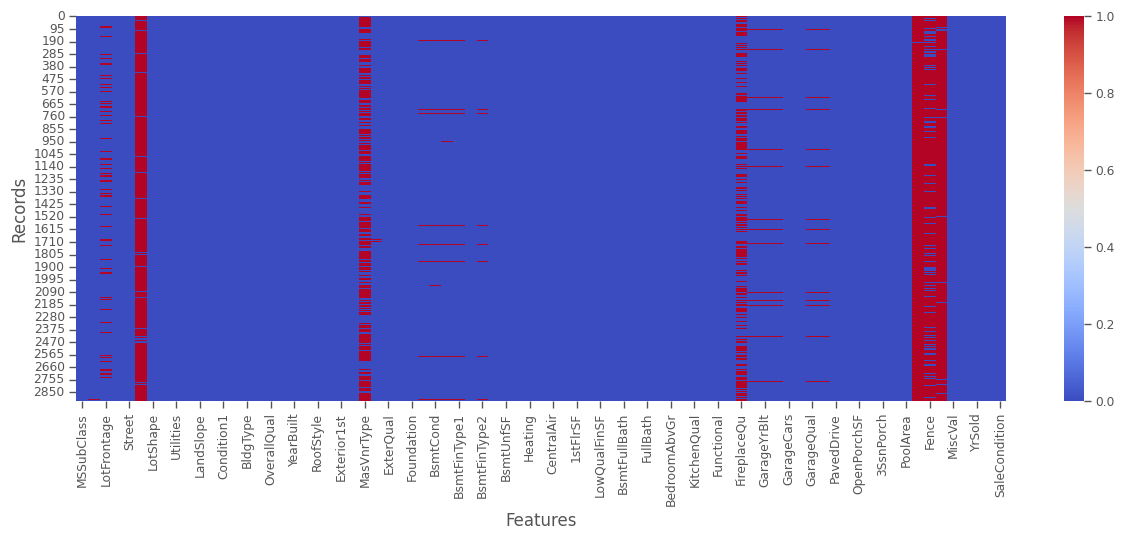

In [9]:
plot_heatmap(df.isna())

MSSubClass is a Categorical Feature therefore changing its data-type.


In [10]:
df['MSSubClass'] = df['MSSubClass'].astype(object)

In [11]:
categorical_features = df.select_dtypes(object).columns
numerical_features = df.select_dtypes(np.number).columns

---
# Cleaning Data

Filling Categorical Features

In [12]:
# Some Features have meaning to their missing values.
# So Converting that feature values to their own value, and converting others with their most common values ( mode ).

for col in df[categorical_features].loc[:, df.isnull().sum() > 0].columns:
    if col in ['Alley', 'MasVnrType','BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1',
                'BsmtFinType2','FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                'PoolQC', 'Fence', 'MiscFeature']:
        df[col] = df[col].fillna("None")
    else:
        df[col] = df[col].fillna(df[col].mode()[0])


Filling Numerical Features

In [13]:
def KNNfilling(df: pd.DataFrame, target_col):
    data = df.copy()
    numeric_data = data.select_dtypes(np.number)
    non_na_cols = numeric_data.loc[:, numeric_data.isnull().sum() == 0].columns

    X_train = numeric_data.loc[~numeric_data[target_col].isna(), non_na_cols]
    y_train = numeric_data.loc[~numeric_data[target_col].isna(), target_col]

    X_test = numeric_data.loc[numeric_data[target_col].isna(), non_na_cols]

    knn = KNeighborsRegressor(7)
    knn.fit(X_train, y_train)

    pred = knn.predict(X_test)

    data.loc[numeric_data[target_col].isna(), target_col] = pred

    return data

In [14]:
for col in df[numerical_features].loc[:, df.isna().sum() > 0].columns:
    df = KNNfilling(df, col)

In [15]:
df.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

---
# Feature Transformation

In [16]:
def visualize_distribution(df, target, colwrap=2, palette='mako'):
    features = df.select_dtypes(np.number).columns
    r = len(features)//colwrap
    fig, ax = plt.subplots(r, colwrap, figsize=(30, 42))
    ax = ax.reshape(-1)
    sns.set_theme(palette=palette)
    fig.suptitle('Distribution of the Data', fontsize=40, y=0.91)
    for feature, subplot in zip(features, ax):
        sns.histplot(df, x=feature, kde=True, bins=50, ax=subplot)
        subplot.set_title(feature.capitalize())
        subplot.set_xlabel(None)
    plt.show()

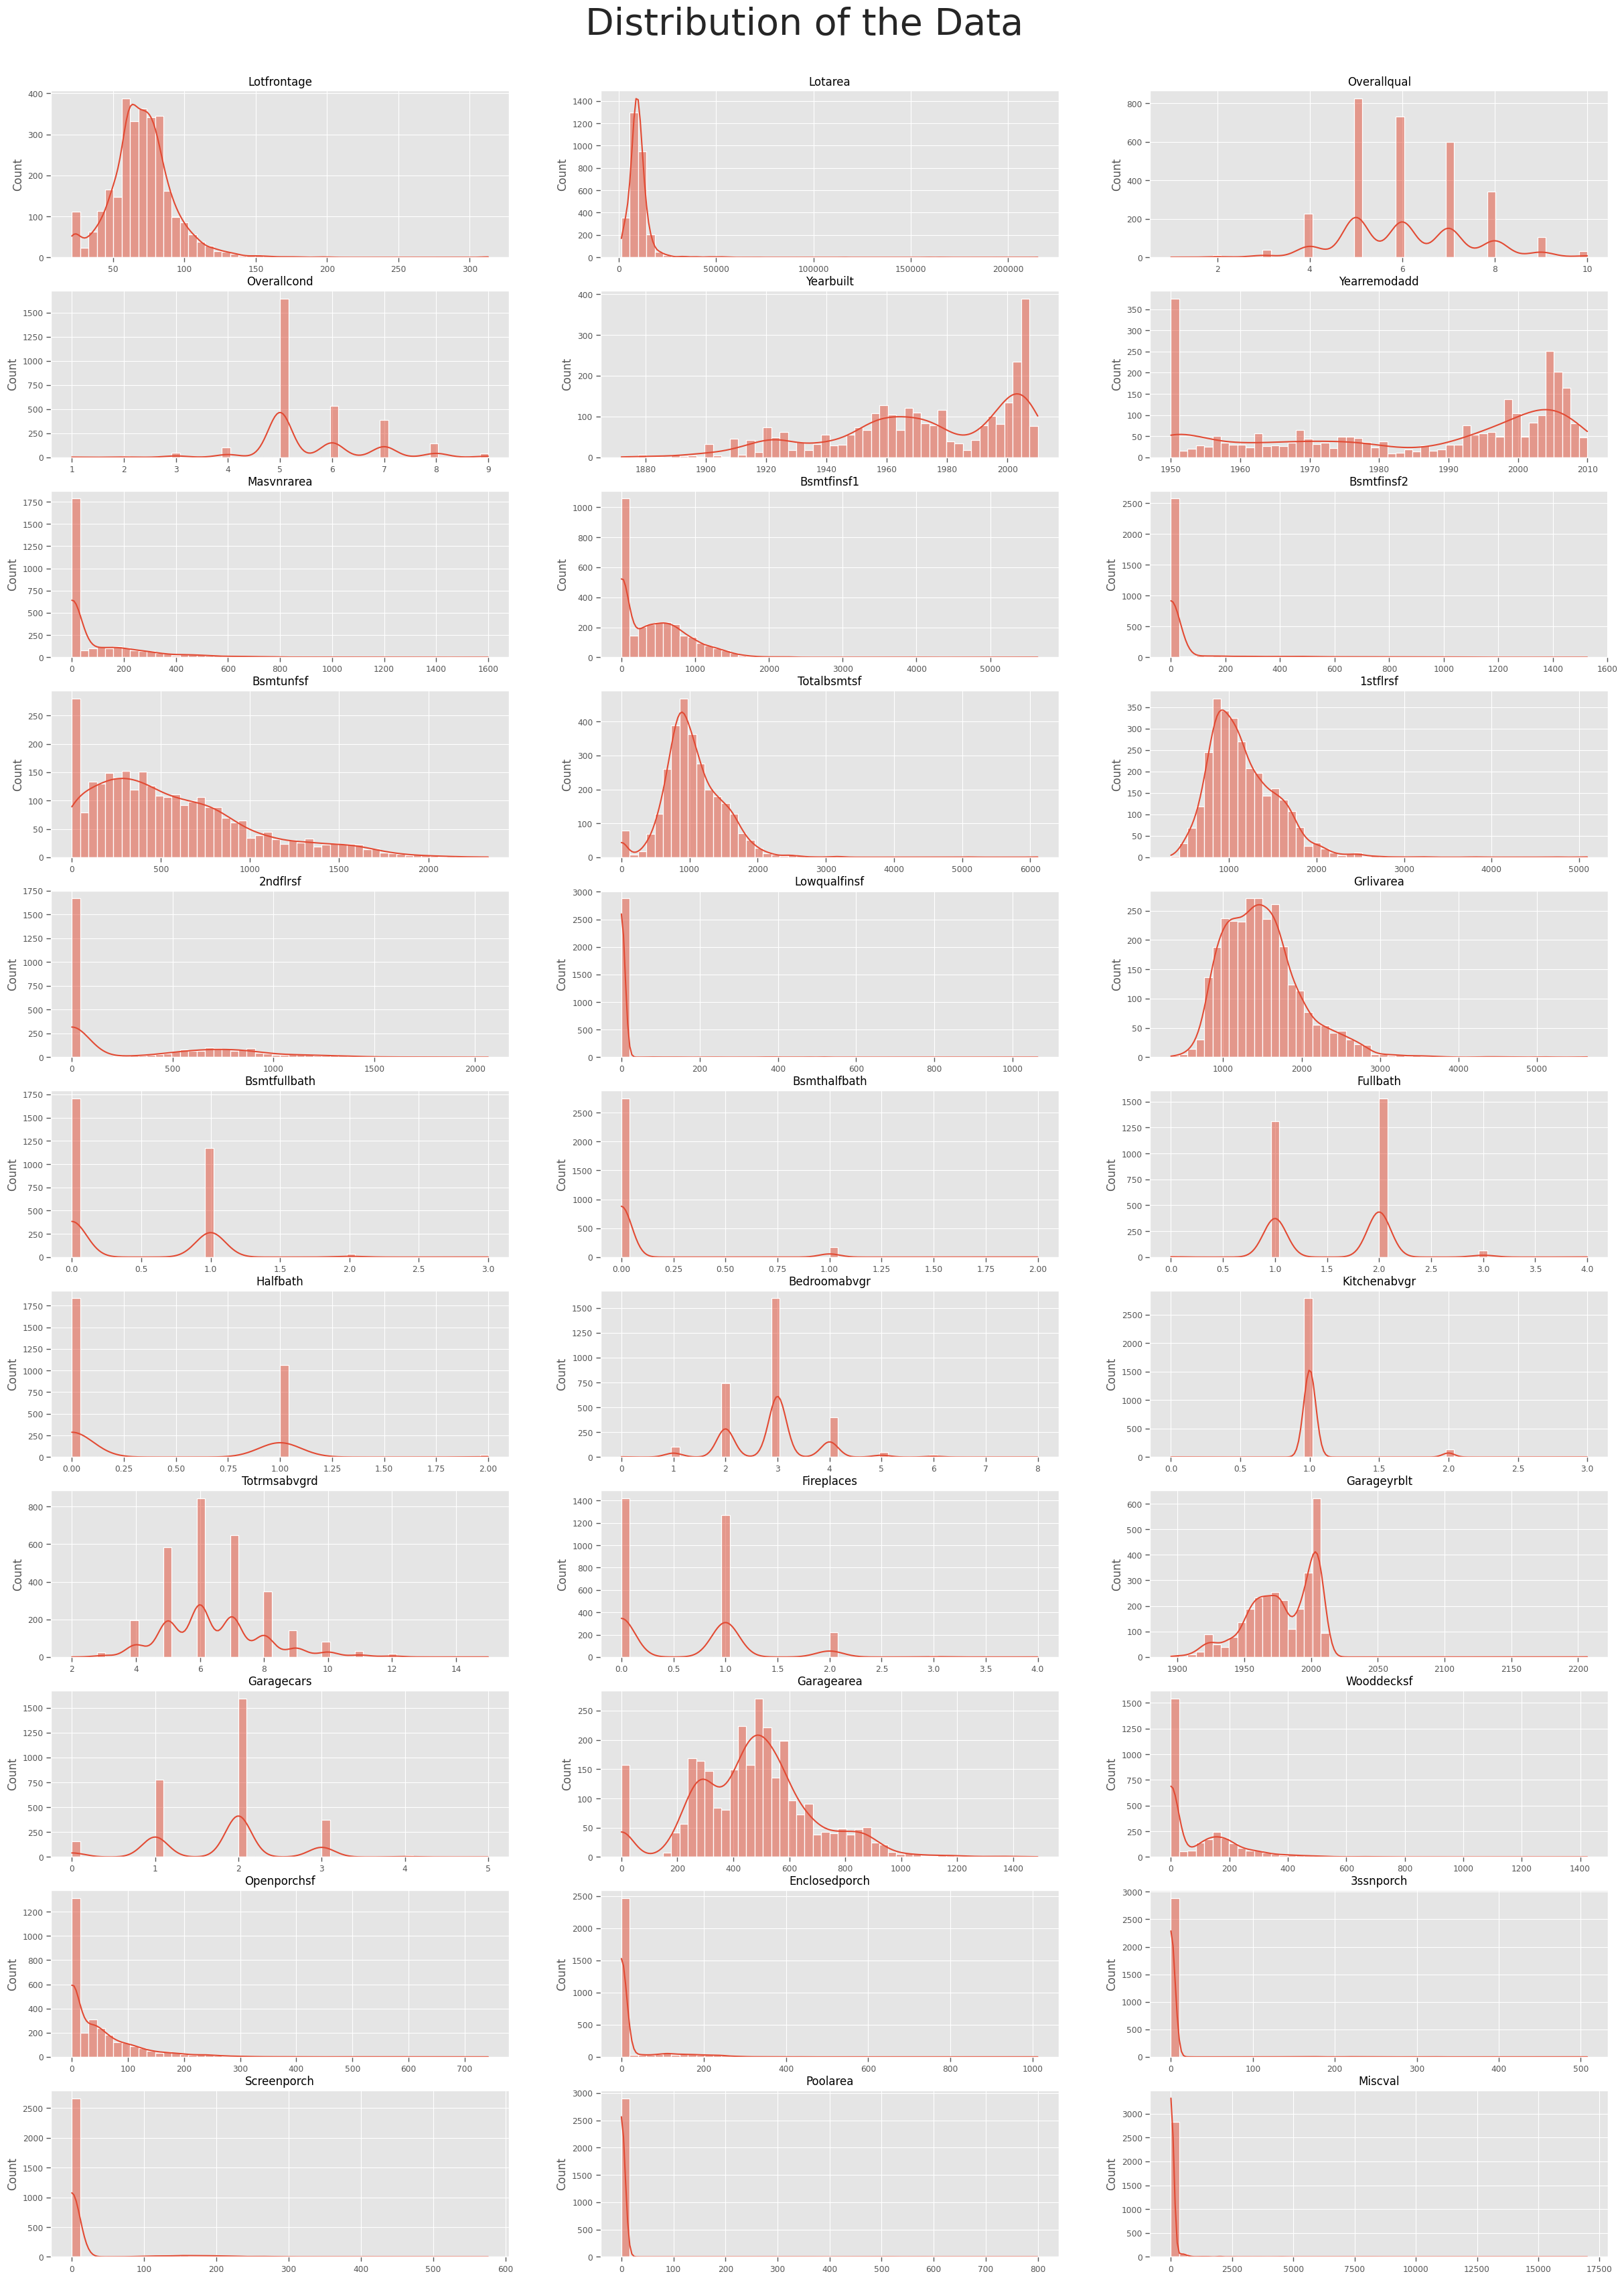

In [17]:
visualize_distribution(df, target, colwrap=3, palette='Set3')

---
# Encoding Data

> 'MoSold' is a cyclic feature, and cyclic function should be applied on it. Like 12 (Dec) is very close to 1(Jan). \
Otherwise, the model will consider that value to be spreaded.

In [18]:
df['MoSold'] = -np.cos(0.5236 * df['MoSold'])

In [19]:
df = pd.get_dummies(df, dtype=int)

---
# Scaling and Applying Decomposition


In [20]:
def apply_log_transform(df, features, contain_zero=False):
    for feature in features:
        if contain_zero:
            df[feature] = np.log1p(df[feature])
        else:
            df[feature] = np.log(df[feature])

In [21]:
apply_log_transform(df, numerical_features, contain_zero=True)

In [22]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

In [23]:
target_scaled = np.log(target)

---
# Seperating the train and test data


In [24]:
f_dict = {}
prev = df.columns
for i in range(5):
    sel = SelectFromModel(
#         LassoCV(random_state=12, max_iter=5000, cv=10),
        RandomForestRegressor(n_estimators=200, random_state=42), 
        threshold='median'
    )
    sel.fit(df.loc[target.index, prev], target_scaled)
    prev = sel.get_feature_names_out()
    f_dict[len(prev)] = prev


In [25]:
f_dict.keys()

dict_keys([158, 79, 40, 20, 10])

In [26]:
train_v1 = df_scaled.loc[target.index, f_dict.get(158)]
test_v1 = df_scaled.loc[ len(target.index): , f_dict.get(158)]

In [27]:
train_v1

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSSubClass_20,MSSubClass_30,MSSubClass_50,MSSubClass_60,MSSubClass_80,MSZoning_C (all),MSZoning_RL,MSZoning_RM,Alley_None,LotShape_IR1,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_IDOTRR,Neighborhood_NAmes,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_Somerst,Condition1_Artery,Condition1_Feedr,Condition1_Norm,BldgType_1Fam,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Mod,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_None,GarageQual_TA,GarageCond_Fa,GarageCond_None,GarageCond_TA,PavedDrive_N,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_None,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal
0,-0.066136,-0.103719,0.682938,-0.435439,1.040634,0.895720,1.209118,0.783275,-0.363048,-0.326974,0.017242,-0.777287,1.196876,-0.116932,0.564627,1.135382,-0.251544,0.812674,1.265077,0.263204,-0.200513,1.016638,-0.986172,1.002988,0.392447,0.343709,-0.945126,0.832979,-0.427545,-0.309144,-0.189329,0.002047,0.157971,-0.765776,-0.223607,-0.330216,2.019040,-0.205251,-0.092944,0.535229,-0.432513,0.269754,-0.704383,0.755115,-0.204343,-0.207057,0.33656,-0.460662,-0.253305,0.607038,0.225291,-0.211515,-0.196011,3.151600,-0.191250,-0.266820,-0.181408,-0.422987,-0.298629,-0.233564,-0.257869,-0.180398,-0.243984,0.403094,0.451344,-0.347185,-1.007911,1.532148,-0.214153,0.513455,-0.087144,-0.482375,-0.175272,-0.422424,-0.426919,-0.286204,1.358319,-0.404816,-0.087144,-0.127925,-0.401945,-0.425236,-0.319257,-0.127925,1.369621,-0.393278,1.523423,-1.237601,-0.305382,-0.195067,-0.110163,1.407698,-1.266462,-0.153272,-0.337820,0.387451,-0.345324,-0.856372,1.109798,-0.311378,1.189282,-0.885568,-0.192211,0.346565,-0.408819,-0.323151,0.730129,-0.415077,-0.318605,1.561462,-0.236,-0.330854,-0.641489,0.413374,0.977304,-0.180398,-0.440301,-0.644683,-0.26829,0.26829,-0.262372,0.304040,-0.274835,-0.156748,1.239377,-1.023223,-0.055613,-0.110163,0.271213,-0.584867,1.027440,-0.126535,-0.504386,0.743411,-0.260878,-0.07187,-0.603340,-0.57168,-0.240018,1.612222,-0.853371,-0.21063,-0.240018,0.347804,-0.161278,-0.240018,0.315989,-0.282686,0.324443,-0.205251,-0.19975,-0.356409,0.493139,-0.298629,0.394439,-0.263861,-0.126535,0.463937
1,0.535701,0.146544,0.038652,1.906370,0.161526,-0.390199,-0.804953,0.892492,-0.363048,0.013398,0.347101

In [28]:
test_v1

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSSubClass_20,MSSubClass_30,MSSubClass_50,MSSubClass_60,MSSubClass_80,MSZoning_C (all),MSZoning_RL,MSZoning_RM,Alley_None,LotShape_IR1,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_IDOTRR,Neighborhood_NAmes,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_Somerst,Condition1_Artery,Condition1_Feedr,Condition1_Norm,BldgType_1Fam,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Mod,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_None,GarageQual_TA,GarageCond_Fa,GarageCond_None,GarageCond_TA,PavedDrive_N,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_None,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal
1460,0.535701,0.521437,-0.705122,0.454875,-0.332070,-1.112208,-0.804953,0.645563,2.285904,-0.013593,0.042663,-0.635877,-0.863610,-0.116932,-1.424253,-0.835006,-0.251544,-1.024719,-0.764608,-1.002234,-0.200513,-0.943755,-0.986172,-0.653645,-0.860662,0.543176,0.964198,-1.083169,-0.427545,2.976640,-0.189329,0.320829,1.678337,1.305865,-0.223607,-0.330216,-0.495285,-0.205251,-0.092944,-1.868360,-0.432513,0.269754,-0.704383,0.755115,-0.204343,-0.207057,0.336560,-0.460662,-0.253305,0.607038,0.225291,-0.211515,-0.196011,-0.317299,-0.19125,-0.26682,-0.181408,2.364141,-0.298629,-0.233564,-0.257869,-0.180398,4.098632,-2.480809,0.451344,-0.347185,0.992151,-0.652679,-0.214153,0.513455,-0.087144,-0.482375,-0.175272,-0.422424,-0.426919,-0.286204,1.358319,-0.404816,-0.087144,-0.127925,-0.401945,-0.425236,-0.319257,-0.127925,1.369621,-0.393278,-0.656416,0.808015,-0.305382,-0.195067,-0.110163,-0.710380,0.789601,-0.153272,-0.33782,0.387451,-0.345324,1.167717,-0.901065,-0.311378,-0.840843,1.129219,-0.192211,0.346565,-0.408819,-0.323151,0.730129,-0.415077,-0.318605,-0.640426,-0.23600,3.022485,-0.641489,-2.419114,-1.023223,-0.180398,-0.440301,1.551150,-0.26829,0.26829,-0.262372,0.30404,-0.274835,-0.156748,-0.806857,0.977304,-0.055613,-0.110163,0.271213,-0.584867,1.027440,-0.126535,-0.504386,0.743411,-0.260878,-0.071870,-0.603340,-0.57168,-0.240018,-0.620262,1.171824,-0.21063,-0.240018,0.347804,-0.161278,-0.240018,0.315989,-0.282686,0.324443,-0.205251,-0.19975,2.805769,-2.027827,-0.298629,0.394439,-0.263861,-0.126535,0.463937
1461,0.571760,0.923625,0.038652,0.454875,-0.431241,-1.257272,0.983490,0.873091,-0.363048,0

---
# Model Training

In [29]:
kf = KFold(n_splits=10, shuffle=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_v1,
                                                    target_scaled,
                                                    test_size=0.2,
                                                    random_state=3,
                                                    shuffle=True)

In [31]:
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (1168, 158)
X_test Shape: (292, 158)
y_train Shape: (1168,)
y_test Shape: (292,)


In [32]:
# def grid_search(model, model_params, cv, n_jobs, X, y):
#     from sklearn.model_selection import GridSearchCV
#     print("Instantiating the Model Training")
#     clf = GridSearchCV(estimator=model, param_grid=model_params, cv=cv, n_jobs=n_jobs, verbose=True, scoring='neg_root_mean_squared_error')
#     clf.fit(X, y)
#     print('Best HyperParameter Settings:', clf.best_estimator_)
#     return clf

In [33]:
# def br_objective(trial: optuna.Trial):

#     params = {
#     'n_iter': trial.suggest_int('n_iter', 1000, 5000),
#     'tol': trial.suggest_float('tol', 0.0001, 1),
#     'alpha_1': trial.suggest_float('alpha_1', 0.001, 50, log=True),
#     'alpha_2': trial.suggest_float('alpha_2', 1, 100, log=True),
#     'lambda_1': trial.suggest_float('lambda_1', 1e-03, 10, log=True),
#     'lambda_2': trial.suggest_float('lambda_2', 0.001, 50, log=True),
#     'compute_score': True,
#     }

#     model = BayesianRidge()
#     model.set_params(**params)
#     result = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)
#     return result.mean()

In [34]:
# br_study = optuna.create_study(direction='minimize')
# br_study.optimize(br_objective, n_trials=300, show_progress_bar=True)
# br_study.best_params

# {'n_iter': 953,
#  'tol': 0.00375320546502597,
#  'alpha_1': 5.766522871715553e-06,
#  'alpha_2': 8.577431593737263,
#  'lambda_1': 0.0009874047777106664,
#  'lambda_2': 5.890703254914883e-07}

#  158
# {'n_iter': 1183,
#  'tol': 0.6910047040486894,
#  'alpha_1': 0.02328510275681388,
#  'alpha_2': 165.73143040361862,
#  'lambda_1': 15.364690666868302,
#  'lambda_2': 0.14151726400987105}

In [35]:
# cat_p = {
#     'bagging_temperature': [1, 3, 5],
#     'learning_rate': [0.001, 0.005, 0.1, 1],
#     'iterations': [1000, 2500, 5000],
#     'l2_leaf_reg': [1, 5, 10],
#     'depth': [4, 8, 12],
#     'iterations': 6000,
# }
# cat = CatBoostRegressor(verbose=10, loss_function='RMSE', eval_metric='RMSE', task_type='GPU', metric_period=150, random_seed=42)
# cat_search = grid_search(cat, cat_p, kf, 1, X_train, y_train)

In [36]:
# cat_search.best_params
# {'iterations': 5000,
# 'learning_rate': 0.005,
# 'depth': 5,
# 'l2_leaf_reg': 3,}

In [42]:
cat_p = {
    'bagging_temperature': 1.3,
    'learning_rate': 0.007,
    'iterations': 5000,
    'l2_leaf_reg': 1.8,
    'depth': 4,
    'silent': True,
}
cat = CatBoostRegressor(eval_metric='RMSE', random_seed=42, **cat_p)
cat.fit(train_v1, target_scaled)
result = np.sqrt(-cross_val_score(cat, train_v1, target_scaled, scoring='neg_mean_squared_error', cv=kf))
result.mean()

0.11610072523236395

In [44]:
br_p = {
 'n_iter': 2000,
 'tol': 1.468606233901514,
 'alpha_1': 0.3777883563812645,
 'alpha_2': 0.4212795793435373,
 'lambda_1': 0.0029375285640210864,
 'lambda_2': 0.0000000000000782323730958113,  
}

br = BayesianRidge(**br_p)
result = -cross_val_score(br, train_v1, target_scaled , scoring='neg_root_mean_squared_error', cv=kf)
br.fit(train_v1, target_scaled)
result.mean()

0.12455987825204821

In [ ]:
# def lgb_objective(trial):
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': -1,
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'n_iterations': 1000,
#         'random_state': 42,
#     }
    
#     model = LGBMRegressor()
#     model.set_params(**params)
#     result = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)
#     return result.mean()
    

In [ ]:
# lgb_study = optuna.create_study(direction='minimize')
# lgb_study.optimize(lgb_objective, n_trials=100, show_progress_bar=True)
# lgb_study.best_params
# {'lambda_l1': 0.004936828919430971,
#  'lambda_l2': 1.0939993729024914e-07,
#  'num_leaves': 84,
#  'feature_fraction': 0.6344861845250082,
#  'bagging_fraction': 0.4413764897864365,
#  'bagging_freq': 1,
#  'min_child_samples': 10,
#  'learning_rate': 0.0736238142408052}

In [47]:
lgb_params = {
    'lambda_l1': 0.004936828919430971,
    'lambda_l2': 0.0939993729024914e-07,
    'num_leaves': 84,
    'feature_fraction': 0.6344861845250082,
    'bagging_fraction': 0.4413764897864365,
    'bagging_freq': 2,
    'min_child_samples': 8,
    'learning_rate': 0.06738142408052,
    'n_iterations': 6000,
    'verbose': -1,
}
lgb = LGBMRegressor(**lgb_params)
result = -cross_val_score(lgb, train_v1, target_scaled, scoring='neg_root_mean_squared_error', cv=kf)
lgb.fit(train_v1, target_scaled)
result.mean()

0.12915688503177783

In [50]:
g_params = {
    'alpha': 0.513,
    'learning_rate': 0.0024,
    'min_samples_split': 4,
    'n_estimators': 2000,
    'random_state': 15,
    'tol': 0.2,
}

gbr = GradientBoostingRegressor(**g_params)
result = -cross_val_score(gbr, train_v1, target_scaled, scoring='neg_root_mean_squared_error', cv=kf)
gbr.fit(train_v1, target_scaled)
result.mean()

0.13564232458666006

In [51]:
# g_preds = gbr.predict(X_test)
# np.sqrt(mean_squared_error(y_test, g_preds))

>Now, using weights of each model to acheive better Performance
But, Prioritizing the CatBosst as the Error in it is less.

In [52]:
# weights = {}

In [53]:
# min_err = 100
# for i in range(1000):
#     w4 = np.random.uniform(0, 0.2)
#     w3 = np.random.uniform(0, 0.2)
#     w2 = np.random.uniform(0, 0.8)
#     w1 = 1 - w2 - w3 - w4
#     t = c_preds*w1 + g_preds*w2 + lgb_preds*w3 + br_preds*w4
#     cer = np.sqrt(mean_squared_error(y_test, t))
#     if cer < min_err:
#         min_err = cer
#         weights[min_err] = w1, w2, w3, w4
        


In [54]:
# print('Minimum Error:', min(weights))
# print('Weights:', weights[min(weights)])

In [55]:
w1, w2, w3, w4 = (0.54, 0.08, 0.11, 0.27)
c_preds = cat.predict(test_v1)
g_preds = gbr.predict(test_v1)
l_preds = lgb.predict(test_v1)
b_preds = br.predict(test_v1)

y_hat = c_preds*w1 + g_preds*w2 + l_preds*w3 + b_preds*w4
np.exp(y_hat)

array([122745.32905035, 157644.50286157, 183829.92021967, ...,
       166973.06065295, 116982.13619151, 228970.15137572])

In [56]:
sub = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': np.exp(y_hat)
})
# sub.to_csv('results.csv', index=None)

In [57]:
sub

,Id,SalePrice
0,1461,122745.329050
1,1462,157644.502862
2,1463,183829.920220
3,1464,196588.390053
4,1465,182810.093770
...,...,...
1454,2915,84307.868961
1455,2916,82263.694715
1456,2917,166973.060653
1457,2918,116982.136192
